# 1. ML Mindset & Problem Framing

**Learning Problem**: Supervised regression (predict continuous `ride_price`) and binary classification (high_cost: price > median).

**Why ML over rules?** Fixed rules ignore interactions like weather+demand; ML learns patterns.

**Model learns**: Correlations e.g., peak demand * traffic → higher price.

## 2. Data Exploration & Understanding

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, r2_score
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/rides.csv')
df.head()


,distance_km,duration_min,time_of_day,traffic_level,weather,demand_level,surge_multiplier,ride_price
0,11.861663,40.311741,morning,medium,clear,high,2.060858,129.668575
1,28.570715,9.627698,afternoon,high,rainy,high,1.228809,151.723339
2,22.227824,13.889579,morning,low,stormy,low,1.864433,144.509370
3,18.361096,54.420480,morning,low,rainy,medium,1.910073,162.413744
4,5.524541,38.353598,afternoon,low,clear,medium,1.636196,55.520592


In [5]:
print(df.info())
print('\\nMissing:', df.isnull().sum())
print('\\nOutliers (ride_price >3std):', len(df[df['ride_price'] > df['ride_price'].mean() + 3*df['ride_price'].std()]))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   distance_km       200 non-null    float64
 1   duration_min      200 non-null    float64
 2   time_of_day       200 non-null    object 
 3   traffic_level     200 non-null    object 
 4   weather           200 non-null    object 
 5   demand_level      200 non-null    object 
 6   surge_multiplier  200 non-null    float64
 7   ride_price        200 non-null    float64
dtypes: float64(4), object(4)
memory usage: 12.6+ KB
None
\nMissing: distance_km         0
duration_min        0
time_of_day         0
traffic_level       0
weather             0
demand_level        0
surge_multiplier    0
ride_price          0
dtype: int64
\nOutliers (ride_price >3std): 3


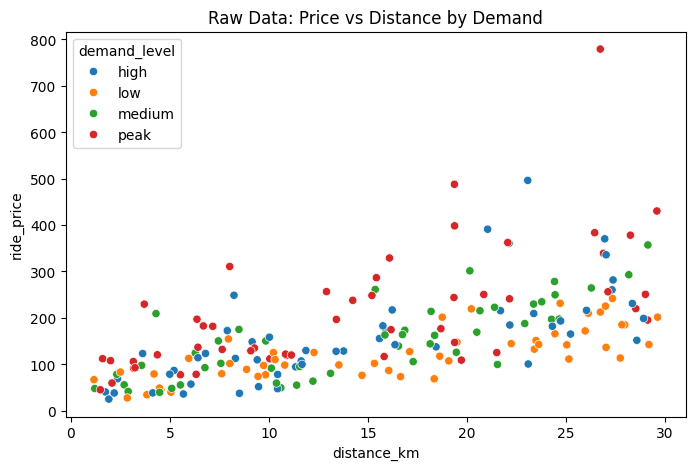

In [6]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='distance_km', y='ride_price', hue='demand_level')
plt.title('Raw Data: Price vs Distance by Demand')
plt.show()

## 3. Data Cleaning & Feature Engineering

**Handling**: No missing. Outliers clipped at 99th percentile.

**Encoding**: OneHotEncoder categorical.

**Scaling**: StandardScaler numerical.

**Poor data impact**: Bias/overfitting from missing/outliers/unscaled features.


In [7]:
price_99 = df['ride_price'].quantile(0.99)
df['ride_price'] = np.clip(df['ride_price'], None, price_99)

target = 'ride_price'
num_feats = ['distance_km', 'duration_min', 'surge_multiplier']
cat_feats = ['time_of_day', 'traffic_level', 'weather', 'demand_level']
X = df[num_feats + cat_feats]
y_reg = df[target]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_feats)
    ])

X_processed = preprocessor.fit_transform(X)
print('Processed shape:', X_processed.shape)


Processed shape: (200, 15)


## 4. Regression Model: Price Prediction

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_reg, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred_reg = reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
r2 = r2_score(y_test, y_pred_reg)
print(f'RMSE: {rmse:.2f}, R²: {r2:.3f}')

RMSE: 28.69, R²: 0.816


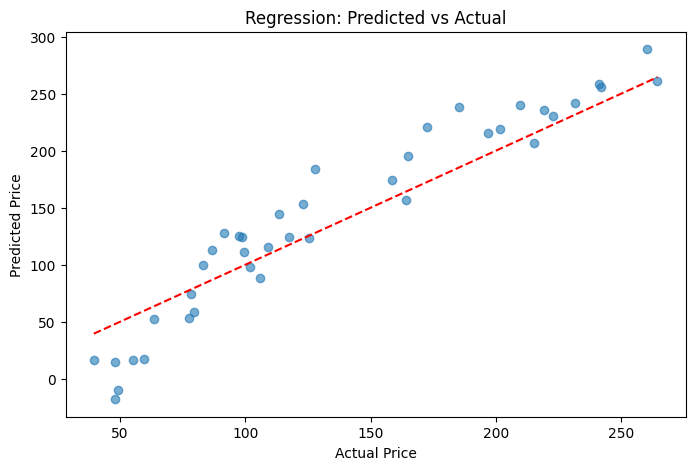

In [9]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_reg, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Regression: Predicted vs Actual')
plt.show()


## 5. Classification Model: High-Cost vs Low-Cost Ride

In [10]:
median_price = y_reg.median()
y_class = (y_reg > median_price).astype(int)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_processed, y_class, test_size=0.2, random_state=42)

clf = LogisticRegression(random_state=42)
clf.fit(X_train_c, y_train_c)
y_pred_class = clf.predict(X_test_c)
acc = accuracy_score(y_test_c, y_pred_class)
print(f'Accuracy: {acc:.3f}')
print('Confusion Matrix:\\n', confusion_matrix(y_test_c, y_pred_class))


Accuracy: 0.975
Confusion Matrix:\n [[24  0]
 [ 1 15]]


**Probabilities**: LogisticRegression.predict_proba() gives P(high_cost). Threshold 0.5 for binary decision.


## 6. Model Evaluation & Comparison


In [11]:
feat_names = num_feats + list(preprocessor.named_transformers_['cat'].get_feature_names_out(cat_feats))
importance = pd.Series(np.abs(reg.coef_), index=feat_names).sort_values(ascending=False)
print(importance.head())

weather_stormy             68.768970
distance_km                60.678117
demand_level_low           54.977272
traffic_level_very_high    51.264255
demand_level_medium        44.759635
dtype: float64


## 7. Ethical & Practical Reflection

- **Unfair pricing**: Surges in high-demand poor areas.
- **Risk**: Unsafe rides during bad weather.
- **Limitation**: Synthetic data lacks real Addis Ababa patterns.
